In [379]:
## Import Libraries
import numpy as np
import copy

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

# from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to save data into files
import pickle as pkl
import os

# Used to measure time
import time

In [380]:
## Import train and test dataset, scale them and convert them to data loaders
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 0.01
MOMENTUM = 0.0

train_dataset = datasets.FashionMNIST(
    root="../adv-ml_challenge1/data/",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)

test_dataset = datasets.FashionMNIST(
    root="../adv-ml_challenge1/data/",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)]),
    download=True,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [381]:
## Randomly select some images from the training and test dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

idx = th.randperm(len(test_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

test_subset_loader = DataLoader(train_dataset, sampler=sampler)

del idx
del sampler

In [382]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_train = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch

    train_subset.append(data.numpy().reshape(1, -1))
    labels_train.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_train = np.array(labels_train)

# Creating dictionary of labels for better understanding
description = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

ticks = list(description.keys())
tick_labels = list(description.values())

torch.Size([64, 1, 28, 28])


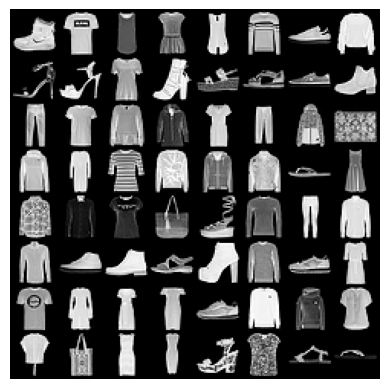

In [383]:
def imshow(img) -> None:
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)), cmap='gray')

# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [384]:
class Classifier_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)
        self.fc1 = nn.Linear(676, 10)
        self.alpha = th.nn.Parameter(th.tensor([0.5, 0.5]))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) - (1 - self.alpha[0]) * F.relu(-x)
        x = self.conv2(x)
        x = F.relu(x) - (1 - self.alpha[1]) * F.relu(-x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        alpha = self.alpha.clone()

        return x, alpha

In [385]:
model = Classifier_Net()
out, _ = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([64, 10])  i.e.: batch_size x num_classes


In [386]:
# choose cross entropy loss function (equation 5.24 in the loss notes)
# loss_function = nn.CrossEntropyLoss()
# Custom loss function
Lambda = 0.1

def loss_function(Lambda, alpha, outputs, labels):
    loss = nn.CrossEntropyLoss()
    result = loss(outputs, labels)
    result += Lambda * alpha.norm()
    return result


# construct SGD optimizer and initialize learning rate and momentum
optimizer = th.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [387]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, test_loader, device, Lambda, alpha):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        test_loss += loss_function(Lambda, alpha, outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc

In [388]:
batch_losses = []
batch_alpha_0 = []
batch_alpha_1 = []


for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(th.device("cpu"))
        labels = labels.to(th.device("cpu"))

        logits, alpha = model(images)
        loss = loss_function(Lambda, model.alpha, logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch
        batch_alpha_0.append(alpha[0].detach())
        batch_alpha_1.append(alpha[1].detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:31<00:00,  7.90s/it]


In [389]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

alpha torch.Size([2])
conv1.weight torch.Size([1, 1, 2, 2])
conv1.bias torch.Size([1])
conv2.weight torch.Size([1, 1, 2, 2])
conv2.bias torch.Size([1])
fc1.weight torch.Size([10, 676])
fc1.bias torch.Size([10])


In [390]:
model.eval()
trained_loss, trained_acc = get_test_stats(model, test_loader, th.device("cpu"), Lambda, model.alpha)

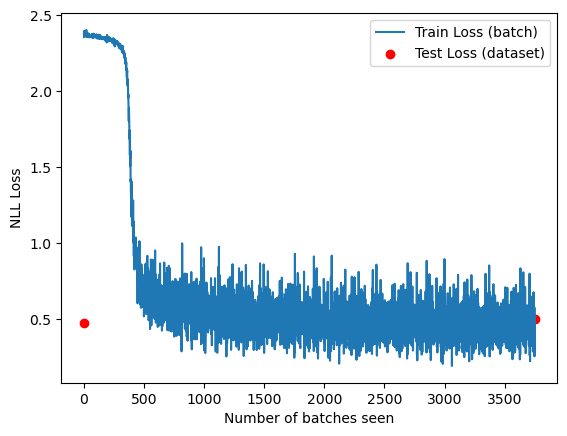

In [391]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ = plt.scatter((xrange[0], xrange[-1]), (untrained_loss, trained_loss), color="red")
_ = plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

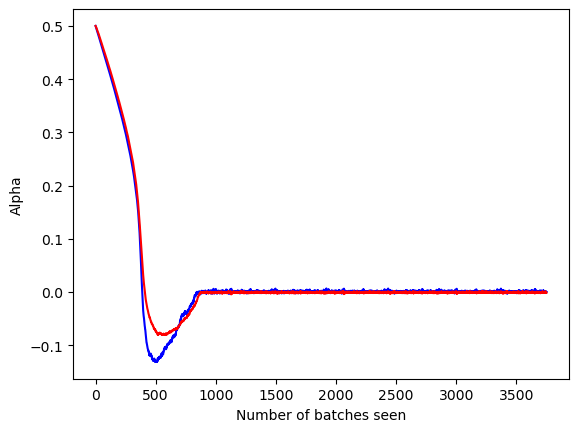

In [394]:
# Plot alpha
xrange = range(len(batch_alpha_0))
_ = plt.plot(xrange, batch_alpha_0, color="blue")
_ = plt.plot(xrange, batch_alpha_1, color="red")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("Alpha")

## Trying to see the network work

Real label: Pullover
prediction: tensor([[ -4.5773,  -7.0793,  -0.6109,  -8.5027,  -4.9041, -17.7764,  -0.8262,
         -17.6271,  -7.3213, -13.7496]])
Predicted class: Pullover


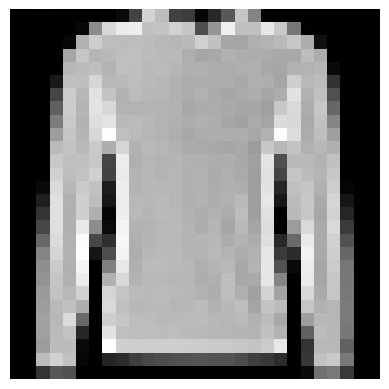

In [393]:
# get single test image
dataiter = test_loader.__iter__()
images, labels = dataiter.__next__()

idx = np.random.choice(images.shape[0])
imshow(images[idx])
print(f"Real label: {description[labels[idx].item()]}")
prediction, _ = model(images[idx])
print(f"prediction: {prediction.detach()}")
predicted_class = th.argmax(prediction, dim=1)
print(f"Predicted class: {description[predicted_class.item()]}")